In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_columns', 90)

## Load the data

In [2]:
# import the train set and assign it to 'df'
df = pd.read_csv('../datasets/train.csv')
# import the test set and assign it to 'holdout'
holdout = pd.read_csv('../datasets/test.csv')

## Describe the basic format of the data and the columns

In [3]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
df.shape

(2051, 81)

In [5]:
print(min(df['Yr Sold']))
print(max(df['Yr Sold']))

2006
2010


In [6]:
holdout.shape

(879, 80)

In [7]:
df.dtypes

Id                  int64
PID                 int64
MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
Lot Area            int64
Street             object
Alley              object
Lot Shape          object
Land Contour       object
Utilities          object
Lot Config         object
Land Slope         object
Neighborhood       object
Condition 1        object
Condition 2        object
Bldg Type          object
House Style        object
Overall Qual        int64
Overall Cond        int64
Year Built          int64
Year Remod/Add      int64
Roof Style         object
Roof Matl          object
Exterior 1st       object
Exterior 2nd       object
Mas Vnr Type       object
Mas Vnr Area      float64
Exter Qual         object
Exter Cond         object
                   ...   
Half Bath           int64
Bedroom AbvGr       int64
Kitchen AbvGr       int64
Kitchen Qual       object
TotRms AbvGrd       int64
Functional         object
Fireplaces          int64
Fireplace Qu

## Rename columns

In [8]:
# replace spaces in column names with underscores
# and convert all to lowercase
# to make working with the data easier
df.columns = [x.replace(" ", "_").lower() for x in df.columns]
holdout.columns = [x.replace(" ", "_").lower() for x in holdout.columns]

## Check Nulls on Train set

In [9]:
nulls = df.isnull().sum().sort_values(ascending=False)
nulls[nulls > 0]

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_cond        114
garage_qual        114
garage_yr_blt      114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_type        22
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_cars          1
garage_area          1
bsmt_unf_sf          1
bsmtfin_sf_2         1
total_bsmt_sf        1
bsmtfin_sf_1         1
dtype: int64

## Check Nulls on Test set

In [10]:
nulls = holdout.isnull().sum().sort_values(ascending=False)
nulls[nulls > 0]

pool_qc           875
misc_feature      838
alley             821
fence             707
fireplace_qu      422
lot_frontage      160
garage_cond        45
garage_qual        45
garage_yr_blt      45
garage_finish      45
garage_type        44
bsmt_exposure      25
bsmtfin_type_1     25
bsmt_qual          25
bsmtfin_type_2     25
bsmt_cond          25
mas_vnr_area        1
mas_vnr_type        1
electrical          1
dtype: int64

## Begin Cleanup by Converting Ordinal Variables, as indicated in the data dictionary
Based on the data dictionary, many null values in the dataset are due to the lowest value in the ordinal scale being entered as NA (e.g. lowest value for "garage_qual" variable is "NA", which correspons to "No Garage") so converting the variables in this fashion will address many null values.

note: this interpretation of the data dictionary's ordinal scales may be mistaken, since it isn't necessarily the case that "No Garage" is worse than a poor quality garage; however, for the scope of this project, that is how the scale was interpreted.

## Convert Ordinal Scales (Ex-Gd-TA-Fa-Po-NA scale)
And impute 0s for nulls, as indicated in the data dictionary

In [11]:
# define a function to convert the 10 ordinal columns 
# with the Ex-Gd-TA-Fa-Po-NA scale to numeric
def ex_scale(df, column_list):
    for column in column_list:
        # replace ordinal objects with ordinal numbers
        df[column] = df[column].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0})
        # convert columns from object to numeric datatype
        df[column] = pd.to_numeric(df[column])
        # replace null values with 0
        df[column] = df[column].fillna(0)
        # check output
        #print(df[column].value_counts())

In [12]:
# run the ex_scale function on the 10 appropriate ordinal columns
column_list = ['bsmt_qual', 
               'bsmt_cond',
               'exter_qual',
               'exter_cond',
               'fireplace_qu',
               'garage_qual',
               'garage_cond',
               'heating_qc',
               'kitchen_qual', 
               'pool_qc']
ex_scale(df, column_list)
ex_scale(holdout, column_list)

## Convert Ordinal Scales (Various scales)
And impute 0s for nulls, as specified in the data dictionary

In [13]:
# define a function to streamline the process
def var_scale(column, reassign_dict, data_set_list = [df, holdout]):
    for data_set in data_set_list:
        data_set[column] = pd.to_numeric(data_set[column].map(reassign_dict))
        data_set[column] = data_set[column].fillna(0)
        #print(data_set[column].value_counts().sum())     
        

In [14]:
var_scale('lot_shape', {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})

In [15]:
var_scale('utilities', {'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0})

In [16]:
var_scale('land_slope', {'Gtl': 2, 'Mod': 1, 'Sev': 0})

In [17]:
var_scale('bsmt_exposure', {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0})

In [18]:
var_scale('bsmtfin_type_1', {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0})

In [19]:
var_scale('bsmtfin_type_2', {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0})

In [20]:
var_scale('electrical', {'SBrkr': 4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 0})

In [21]:
var_scale('functional', {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0})

In [22]:
var_scale('garage_finish', {'Fin': 3, 'Rfn': 2, 'Unf': 1})

In [23]:
var_scale('paved_drive', {'Y': 2, 'P': 1, 'N': 0})

In [24]:
var_scale('fence', {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NA': 0})

## Binarize 'central_air'

In [25]:
# convert binary 'central_air' column to 1 for yes, 0 for no
df['central_air'] = pd.to_numeric(df.central_air.map({'Y': 1, 'N': 0}))

## Re-Check Nulls on Overall training set

In [26]:
nulls = df.isnull().sum().sort_values(ascending=False)
nulls[nulls > 0]

misc_feature      1986
alley             1911
lot_frontage       330
garage_yr_blt      114
garage_type        113
mas_vnr_type        22
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
bsmtfin_sf_1         1
garage_cars          1
garage_area          1
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
dtype: int64

## Re-Check Nulls on Test set

In [27]:
nulls = holdout.isnull().sum().sort_values(ascending=False)
nulls[nulls > 0]

misc_feature     838
alley            821
lot_frontage     160
garage_yr_blt     45
garage_type       44
mas_vnr_area       1
mas_vnr_type       1
dtype: int64

## drop 'misc_features', 'alley', 'lot_frontage', 'garage_yr_blt', 'garage_area'
These columns have too many null values to reasonably impute values or drop rows based on nulls.

In [28]:
drop_column_list = ['misc_feature', 'alley', 'lot_frontage', 'garage_yr_blt', 'garage_type']
df.drop(columns = drop_column_list, inplace=True)
holdout.drop(columns = drop_column_list, inplace=True)

## 'garage_area' & 'garage_cars'

#### Find Training row with null value for 'garage_area' (same row that contains null value for 'garage_cars'
I may want to use this as a feature, since it has a high correlation with the the target (0.65), and I will either drop the entire row or I can infer that the building has no garage if other garage columns imply that.

In [29]:
df[df['garage_area'].isnull()]

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,yr_sold,sale_type,saleprice
1712,2237,910201180,70,RM,9060,Pave,3,Lvl,3,Inside,2,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,3,3,BrkTil,4.0,3.0,1.0,5.0,548.0,1.0,0.0,311.0,859.0,GasA,5,1,4,942,886,0,1828,0.0,0.0,2,0,3,1,4,6,7,0,0.0,0.0,NaN,NaN,0.0,0.0,2,174,0,212,0,0,0,0.0,3.0,0,3,2007,WD,150909


#### Drop the row, since there is an entry that say the property has a 'detached' garage, and therefore I can't impute any info about the garage

In [30]:
df.drop([1712], inplace=True)

## 'total_bsmt_sf'
#### Find Training row with null value for 'total_bsmt_sf'
I may want to use this as a feature, since it has a high correlation with the the target (0.63), and I believe I can infer that the building has no basement if the other basement columns imply that.

In [31]:
df[df['total_bsmt_sf'].isnull()]

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,yr_sold,sale_type,saleprice
1327,1342,903230120,20,RM,5940,Pave,2,Lvl,3,FR3,2,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,3,3,PConc,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,GasA,3,1,3,896,0,0,896,NaN,NaN,1,0,2,1,3,4,7,0,0.0,1.0,1.0,280.0,3.0,3.0,2,0,0,0,0,0,0,0.0,3.0,0,4,2008,ConLD,79000


#### Impute a value of 0 for total_bsmt_sf, since I believe this property has no basement.

In [32]:
df.set_value(1327, 'total_bsmt_sf', 0)
df.loc[1327]['total_bsmt_sf']

/Users/kevinc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


0.0

## Drop remaining null values in train set
There are few enough null columns left to remove them without seriously affecting out train set (22 of 2051 is about 1 percent)

In [33]:
nulls = df.isnull().sum().sort_values(ascending=False)
nulls[nulls > 0]

mas_vnr_type      22
mas_vnr_area      22
bsmt_full_bath     2
bsmt_half_bath     2
bsmtfin_sf_2       1
bsmtfin_sf_1       1
bsmt_unf_sf        1
dtype: int64

In [34]:
df.dropna(inplace=True)

## Find remaining null values in test set

In [35]:
nulls = holdout.isnull().sum().sort_values(ascending=False)
nulls[nulls > 0]

mas_vnr_type    1
mas_vnr_area    1
dtype: int64

In [36]:
holdout[holdout['mas_vnr_type'].isnull()]

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,yr_sold,sale_type
866,868,907260030,60,RL,8749,Pave,3,Lvl,3,Inside,2,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,4,3,PConc,4.0,3.0,1.0,1.0,0,1.0,0,840,840,GasA,5,Y,4.0,840,885,0,1725,0,0,2,1,3,1,4,6,7,0,0.0,0.0,2,550,3.0,3.0,2,0,48,0,0,0,0,0.0,0.0,0,11,2009,WD


Since this property has vinyl siding, I can infer that it does not have masonry veneer. I'll impute 'None' for mas_vnr_type and 0 for mas_vnr_area

In [37]:
holdout.set_value(866, 'mas_vnr_type', 'None')
holdout.set_value(866, 'mas_vnr_area', 0)

/Users/kevinc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/Users/kevinc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,9142,Pave,3,Lvl,3,Inside,2,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,3,2,Stone,2.0,3.0,1.0,1.0,0,1.0,0,1020,1020,GasA,4,N,1.0,908,1020,0,1928,0,0,2,0,4,2,2,9,7,0,0.0,1.0,1,440,1.0,1.0,2,0,60,112,0,0,0,0.0,0.0,0,4,2006,WD
1,2718,905108090,90,RL,9662,Pave,2,Lvl,3,Inside,2,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,3,3,CBlock,4.0,3.0,1.0,1.0,0,1.0,0,1967,1967,GasA,3,Y,4.0,1967,0,0,1967,0,0,2,0,6,2,3,10,7,0,0.0,3.0,2,580,3.0,3.0,2,170,0,0,0,0,0,0.0,0.0,0,8,2006,WD
2,2414,528218130,60,RL,17104,Pave,2,Lvl,3,Inside,2,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,4,3,PConc,4.0,4.0,3.0,6.0,554,1.0,0,100,654,GasA,5,Y,4.0,664,832,0,1496,1,0,2,1,3,1,4,7,7,1,4.0,0.0,2,426,3.0,3.0,2,100,24,0,0,0,0,0.0,0.0,0,9,2006,New
3,1989,902207150,30,RM,8520,Pave,3,Lvl,3,Inside,2,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,4,3,CBlock,3.0,3.0,1.0,1.0,0,1.0,0,968,968,GasA,3,Y,4.0,968,0,0,968,0,0,1,0,2,1,3,5,7,0,0.0,1.0,2,480,2.0,3.0,0,0,0,184,0,0,0,0.0,0.0,0,7,2007,WD
4,625,535105100,20,RL,9500,Pave,2,Lvl,3,Inside,2,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,3,3,CBlock,4.0,3.0,1.0,4.0,609,1.0,0,785,1394,GasA,4,Y,4.0,1394,0,0,1394,1,0,1,1,3,1,3,6,7,2,4.0,0.0,2,514,3.0,3.0,2,0,76,0,0,185,0,0.0,0.0,0,7,2009,WD
5,333,923228370,160,RM,1890,Pave,3,Lvl,3,Inside,2,MeadowV,Norm,Norm,TwnhsE,2Story,4,6,1972,1972,Gable,CompShg,CemntBd,CmentBd,None,0.0,3,3,CBlock,3.0,3.0,1.0,3.0,294,1.0,0,252,546,GasA,3,Y,4.0,546,546,0,1092,0,0,1,1,3,1,3,5,7,0,0.0,1.0,1,286,3.0,3.0,2,0,0,64,0,0,0,0.0,0.0,0,6,2010,WD
6,1327,902427150,20,RM,8516,Pave,3,Lvl,3,Inside,2,OldTown,Norm,Norm,1Fam,1Story,4,6,1958,2006,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,3.0,3.0,1.0,1.0,0,1.0,0,869,869,GasA,3,Y,4.0,1093,0,0,1093,0,0,1,0,2,1,3,5,7,0,0.0,1.0,1,308,3.0,3.0,2,0,0,0,0,0,0,0.0,0.0,0,5,2008,WD
7,858,907202130,20,RL,9286,Pave,2,Lvl,3,CulDSac,1,CollgCr,Norm,Norm,1Fam,1Story,5,7,1977,1989,Gable,CompShg,HdBoard,Plywood,None,0.0,3,3,CBlock,4.0,4.0,3.0,5.0,196,1.0,0,1072,1268,GasA,3,Y,4.0,1268,0,0,1268,0,0,1,1,3,1,4,5,7,0,0.0,1.0,1,252,3.0,3.0,2,173,0,0,0,0,0,0.0,0.0,0,10,2009,WD
8,95,533208090,160,FV,3515,Pave,3,Lvl,3,Inside,2,Somerst,Norm,Norm,TwnhsE,2Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,4,3,PConc,4.0,3.0,1.0,1.0,0,1.0,0,840,840,GasA,5,Y,4.0,840,840,0,1680,0,0,2,1,2,1,4,3,7,0,0.0,0.0,2,588,3.0,3.0,2,0,111,0,0,0,0,0.0,0.0,0,1,2010,WD
9,1568,914476010,20,RL,10125,Pave,3,Lvl,3,Inside,2,Mitchel,Norm,Norm,1Fam,1Story,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,3,3,CBlock,3.0,3.0,1.0,5.0,641,2.0,279,276,1196,GasA,3,Y,4.0,1279,0,0,1279,0,1,2,0,3,1,3,6,7,2,2.0,1.0,2,473,3.0,3.0,2,238,83,0,0,0,0,0.0,3.0,0,2,2008,WD


## Describe the summary statistics for the columns

In [38]:
df.describe()

,id,pid,ms_subclass,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,yr_sold,saleprice
count,2026.000000,2.026000e+03,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.00000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000,2026.000000
mean,1472.936328,7.145517e+08,57.134748,10038.427937,2.597730,2.998519,1.946693,6.101185,5.567127,1971.415597,1983.98075,99.843534,3.400296,3.086871,3.484699,2.930405,1.632280,3.567127,442.010365,1.276900,48.380553,566.524186,1056.915104,4.151037,0.930405,3.884501,1162.434353,328.574531,5.580948,1496.589832,0.427443,0.064166,1.571570,0.367720,2.843534,1.042942,3.510365,6.434353,6.843040,0.589339,1.758144,1.153011,1.773445,472.959526,2.803554,2.810958,1.832675,94.153998,47.002468,22.548371,2.623396,16.715202,2.427443,0.015301,0.580948,52.210760,6.210267,2007.778875,180903.863771
std,845.609327,1.887049e+08,42.943214,6707.696525,0.566187,0.049668,0.245697,1.425042,1.107410,30.145229,21.03601,175.050567,0.587256,0.374964,0.894986,0.567075,1.080249,2.120257,460.792112,0.950545,165.804215,444.362373,449.006257,0.965013,0.254526,0.404282,391.544288,425.284319,51.379446,498.902093,0.522971,0.253039,0.547101,0.499406,0.826535,0.209955,0.663802,1.559957,0.682076,0.638025,1.806093,1.138456,0.765623,216.184467,0.720019,0.714781,0.536231,128.923298,66.076293,59.760393,25.383222,57.697759,38.014135,0.237815,1.217004,576.893785,2.742480,1.314860,79112.847055
min,1.000000,5.263011e+08,20.000000,1300.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1872.000000,1950.00000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,751.250000,5.284770e+08,20.000000,7500.000000,2.000000,3.000000,2.000000,5.000000,5.000000,1953.000000,1964.00000,0.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,220.000000,793.000000,3.000000,1.000000,4.000000,879.250000,0.000000,0.000000,1126.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,5.000000,7.000000,0.000000,0.000000,0.000000,1.000000,317.500000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1480.500000,5.354541e+08,50.000000,9402.500000,3.000000,3.000000,2.000000,6.000000,5.000000,1974.000000,1993.00000,0.000000,3.000000,3.000000,4.000000,3.000000,1.000000,4.000000,368.000000,1.000000,0.000000,474.000000,994.000000,5.000000,1.000000,4.000000,1092.000000,0.000000,0.000000,1442.000000,0.00000

## Check distributions

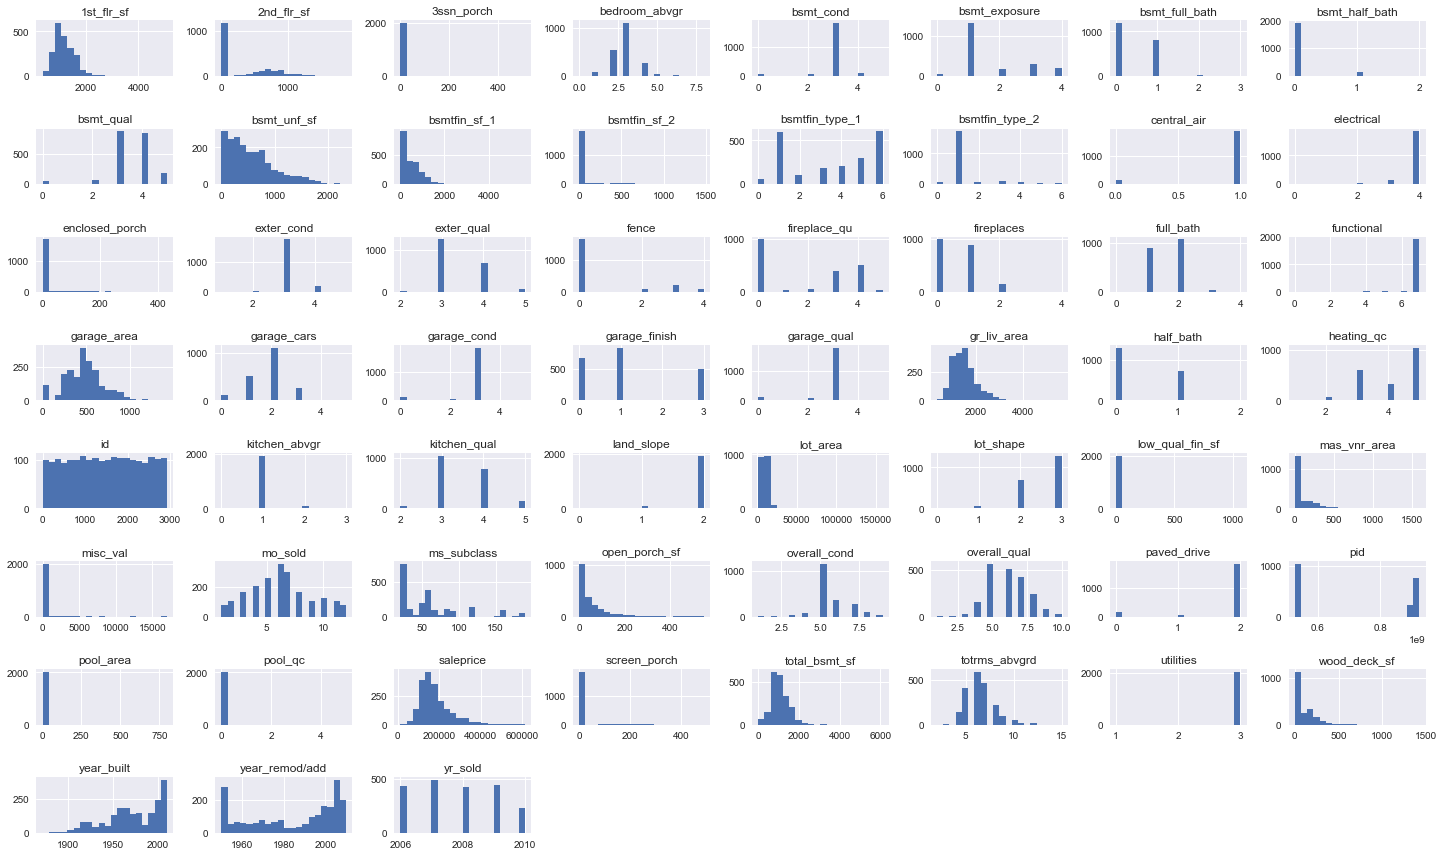

In [39]:
df.hist(figsize=(20, 12), bins = 20)
plt.tight_layout();

## Check correlations relative to target

In [40]:
corr_results = df.corr()[['saleprice']].sort_values('saleprice', ascending=False)
corr_filter = corr_results[abs(corr_results.saleprice > 0.6)]
corr_filter.index

Index(['saleprice', 'overall_qual', 'exter_qual', 'gr_liv_area',
       'kitchen_qual', 'garage_area', 'garage_cars', 'total_bsmt_sf',
       '1st_flr_sf', 'bsmt_qual'],
      dtype='object')

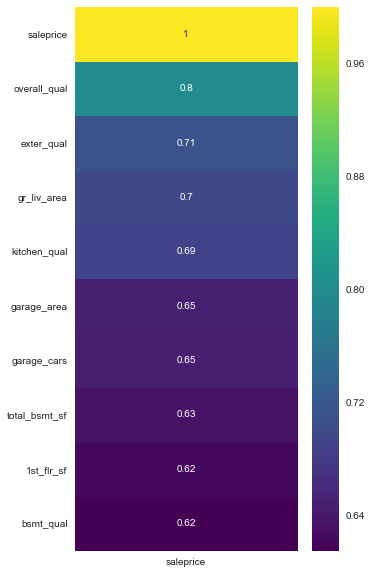

In [41]:
plt.figure(figsize=(5,10))
sns.heatmap(corr_filter, annot=True, cmap = 'viridis');

## Check correlations among the potential features
  
high correlations on:  
- garage_area AND garage_cars
- fireplaces AND fireplace_qu
- garage_yr_built AND year_built
- gr_live_area AND totrms_abvgrd

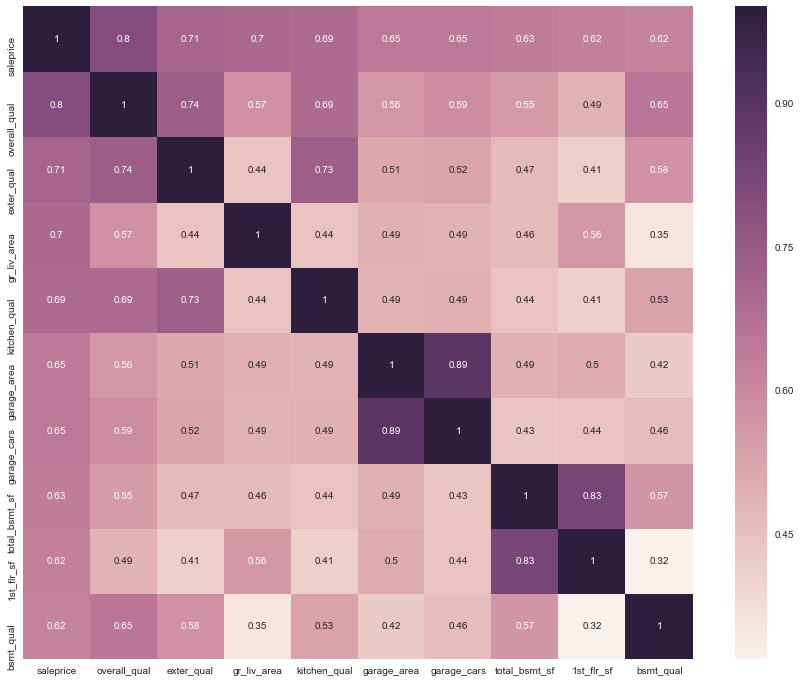

In [42]:
plt.figure(figsize = (15,12))
sns.heatmap(df[corr_filter.index].corr(), annot=True)

## Check for Outliers

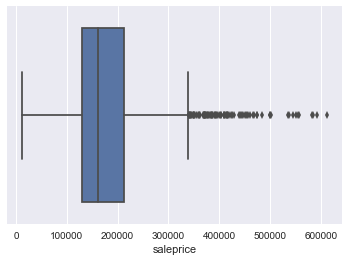

In [49]:
sns.boxplot(df.saleprice)

Looks like our target variable is skewed right.

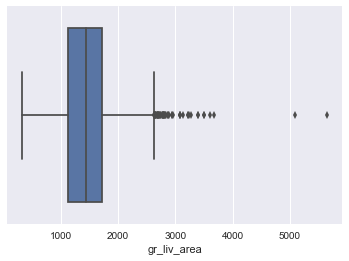

In [44]:
sns.boxplot(df.gr_liv_area)

Above-Grade Living Area, one of our main input variables, has a couple of significant outliers.

In [45]:
df[df.gr_liv_area > 5000]

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,yr_sold,sale_type,saleprice
960,1499,908154235,60,RL,63887,Pave,0,Bnk,3,Corner,2,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,5,3,PConc,5.0,3.0,4.0,6.0,5644.0,1.0,0.0,466.0,6110.0,GasA,5,1,4,4692,950,0,5642,2.0,0.0,2,1,3,1,5,12,7,3,4.0,3.0,2.0,1418.0,3.0,3.0,2,214,292,0,0,0,480,4.0,0.0,0,1,2008,New,160000
1885,2181,908154195,20,RL,39290,Pave,2,Bnk,3,Inside,2,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,5,3,PConc,5.0,3.0,4.0,6.0,4010.0,1.0,0.0,1085.0,5095.0,GasA,5,1,4,5095,0,0,5095,1.0,1.0,2,1,2,1,5,15,7,2,4.0,3.0,3.0,1154.0,3.0,3.0,2,546,484,0,0,0,0,0.0,0.0,17000,10,2007,New,183850


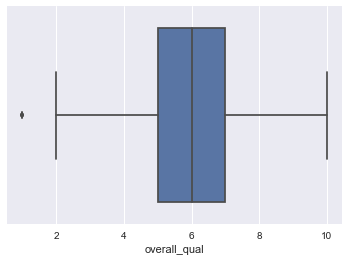

In [46]:
sns.boxplot(df.overall_qual)

A score of one on Overall Quality is an outlier.

In [47]:
df[df.overall_qual == 1]

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,yr_sold,sale_type,saleprice
183,1554,910251050,20,A (agr),14584,Pave,3,Low,3,Inside,1,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,2,1,Slab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wall,1,0,3,733,0,0,733,0.0,0.0,1,0,2,1,2,4,0,0,0.0,1.0,2.0,487.0,2.0,1.0,0,0,0,0,0,0,0,0.0,0.0,0,2,2008,WD,13100
635,2904,923125030,20,A (agr),31250,Pave,3,Lvl,3,Inside,2,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,3,2,CBlock,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GasA,3,1,3,1600,0,0,1600,0.0,0.0,1,1,3,1,3,6,4,0,0.0,1.0,1.0,270.0,2.0,3.0,0,0,0,135,0,0,0,0.0,0.0,0,5,2006,WD,81500
1372,766,904301375,30,RL,10020,Pave,2,Low,3,Inside,0,Edwards,Norm,Norm,1Fam,1Story,1,1,1922,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,2,2,BrkTil,2.0,1.0,4.0,4.0,350.0,1.0,0.0,333.0,683.0,GasA,4,0,3,904,0,0,904,1.0,0.0,0,1,1,1,2,4,3,0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0.0,0.0,0,3,2009,WD,61000
1428,1902,534450090,20,RL,5000,Pave,3,Low,3,Inside,1,BrkSide,Norm,Norm,1Fam,1Story,1,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,Slab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GasA,2,0,2,334,0,0,334,0.0,0.0,1,0,1,1,2,2,7,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,1,2007,WD,39300


## Save cleaned datasets to new csv's

In [48]:
df.to_csv('../datasets/df_clean.csv')
holdout.to_csv('../datasets/holdout_clean.csv')